In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from preprocessing import preprocess
from gating import *

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
data_path = '../data/'
course = 'dsp_001'
path = data_path + course + '/'
percentile = 0.4
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')

x_train, x_test, x_val, y_train, y_test, y_val, feature_names, patterns = preprocess(course, path, percentile, feature_types, metadata)

In [2]:
# Concat features & labels for later analysis
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)
P = np.concatenate(patterns, axis=0)

### Feature gating with annealing loss


In [3]:
# Set up parameters and model to train
meta = {'gumbel_temp': 1, 'gumbel_noise': 1e-8}
params = {
    'epochs': 20,
    'batch_size': 64,
    'optimizer': tf.keras.optimizers.Adam()
}
model = MaskingModel(n_groups=x_train.shape[-1])

In [8]:
# Train model
scores = custom_train(model, params, meta, x_train, y_train, x_val, y_val)

Epoch 0: 	 0.4353 loss 	&	 0.5077 ROC AUC
Validation 0: 	 14.3279 loss 	&	 0.5000 ROC AUC
Epoch 1: 	 0.2826 loss 	&	 0.8296 ROC AUC
Validation 1: 	 0.4922 loss 	&	 0.9097 ROC AUC
Epoch 2: 	 0.2612 loss 	&	 0.8991 ROC AUC
Validation 2: 	 0.3451 loss 	&	 0.9576 ROC AUC
Epoch 3: 	 0.2410 loss 	&	 0.9171 ROC AUC
Validation 3: 	 0.3386 loss 	&	 0.9577 ROC AUC
Epoch 4: 	 0.2299 loss 	&	 0.9230 ROC AUC
Validation 4: 	 0.3336 loss 	&	 0.9564 ROC AUC
Epoch 5: 	 0.2236 loss 	&	 0.9260 ROC AUC
Validation 5: 	 0.3576 loss 	&	 0.9563 ROC AUC
Epoch 6: 	 0.2196 loss 	&	 0.9275 ROC AUC
Validation 6: 	 0.3625 loss 	&	 0.9539 ROC AUC
Epoch 7: 	 0.2181 loss 	&	 0.9263 ROC AUC
Validation 7: 	 0.3494 loss 	&	 0.9566 ROC AUC
Epoch 8: 	 0.2146 loss 	&	 0.9280 ROC AUC
Validation 8: 	 0.3671 loss 	&	 0.9534 ROC AUC
Epoch 9: 	 0.2124 loss 	&	 0.9296 ROC AUC
Validation 9: 	 0.3520 loss 	&	 0.9539 ROC AUC
Epoch 10: 	 0.2090 loss 	&	 0.9326 ROC AUC
Validation 10: 	 0.3616 loss 	&	 0.9511 ROC AUC
Epoch 11: 	 0.2080

In [9]:
# Save model
model.save_weights(MODEL_PATH + 'annealing_fg')

In [4]:
# Load model
model.load_weights(MODEL_PATH + 'annealing_fg')

In [5]:
# Get masks
masks = model.get_mask(X, meta)
# Reduce over feature
f_activated = tf.reduce_sum(masks, axis=0)
f_activated

<tf.Tensor: shape=(45,), dtype=float32, numpy=
array([ 4089.,     0.,     0.,     0.,     0.,     0.,     0.,  4225.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,  3893.,  3811.,  3980.,     0.,     0.,
           0.,     0.,     0.,     0., 17511.,     0.,     0.,     0.,
           0.,  4564.,     0., 17511.,     0.], dtype=float32)>

In [6]:
f_activations = [(feature_names[i], f_activated[i].numpy()) for i in tf.where(f_activated)[:, 0]]
f_activations

[('total_clicks_Video.Load', 4089.0),
 ('total_clicks_Video', 4225.0),
 ('time_sessions sum', 3893.0),
 ('time_sessions mean', 3811.0),
 ('time_between_sessions std', 3980.0),
 ('time_in__problem sum', 17511.0),
 ('content_alignment', 4564.0),
 ('student_speed', 17511.0)]

In [7]:
# Truncate to activated features
activated = tf.where(f_activated)[:, 0]
masks_a = tf.gather(masks, activated, axis=-1)
X_a = tf.gather(X, activated, axis=-1)

In [8]:
X_a = X_a.numpy()

In [9]:
# Expand masks to repeat for each week
masks_expanded = tf.expand_dims(masks_a, axis=1)
masks_expanded = tf.repeat(masks_expanded, repeats=[X_a.shape[1]], axis=1)
# masks_expanded.shape
X_masked = masks_expanded*X_a
# Flatten to 2D 
X_masked = tf.reshape(X_masked,[X_masked.shape[0], X_masked.shape[1]*X_masked.shape[2]])

In [10]:
X_masked.shape

TensorShape([17511, 32])

In [11]:
X_flatten = tf.reshape(X,[X.shape[0], X.shape[1]*X.shape[2]])

In [12]:
X_flatten.shape

TensorShape([17511, 180])

In [210]:
def compute_number_clusters(data):
    best_score = 0
    best_n = 0
    n = 3
    while 1:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        print("Silhouette score {0} with {1} clusters".format(score, n))
#         if score > best_score:
#             best_score = score
#             best_n = n
        n += 1
        if n > 10:
            break
            
compute_number_clusters(X_flatten)

Silhouette score 0.2574315040392473 with 3 clusters
Silhouette score 0.25687448842578653 with 4 clusters
Silhouette score 0.26563728421659616 with 5 clusters
Silhouette score 0.28664477903556507 with 6 clusters
Silhouette score 0.2772715590392423 with 7 clusters
Silhouette score 0.291044925580345 with 8 clusters
Silhouette score 0.307299841665956 with 9 clusters
Silhouette score 0.29289404729378754 with 10 clusters


### Baseline

In [79]:
n = 6

data = X_flatten
kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
labels = kmeans.labels_
silhouette_score(data, labels)

0.28664477903556507

In [80]:
import umap

def plot_tsne_and_pca(data, labels, pca_before=False):    
    #PCA
    pca2 = PCA(n_components=2)
    PCA2 = pca2.fit_transform(data)
    dfpca = pd.DataFrame(PCA2)
    dfpca['cluster'] = labels
    dfpca.columns = ['x1','x2','cluster']
    
    # TSNE
    if pca_before:
        pca7 = PCA(n_components=7)
        PCA7 = pca2.fit_transform(data) 
    
        Xtsne = TSNE(n_components=2).fit_transform(PCA7)
        dftsne = pd.DataFrame(Xtsne)
        dftsne['cluster'] = labels
        dftsne.columns = ['x1','x2','cluster']
    else:
        Xtsne = TSNE(n_components=2).fit_transform(data)
        dftsne = pd.DataFrame(Xtsne)
        dftsne['cluster'] = labels
        dftsne.columns = ['x1','x2','cluster']
        
    # UMAP
    reducer = umap.UMAP(n_components=2)
    umap2 = reducer.fit_transform(data)
    dfumap = pd.DataFrame(umap2)
    dfumap['cluster'] = labels
    dfumap.columns = ['x1', 'x2', 'cluster']
    
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
    ax[0].set_title('Visualized on TSNE 2D')
    sns.scatterplot(data=dfpca,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
    ax[1].set_title('Visualized on PCA 2D')
    sns.scatterplot(data=dfumap,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[2])
    ax[2].set_title('Visualized on UMAP 2D')
    plt.show()

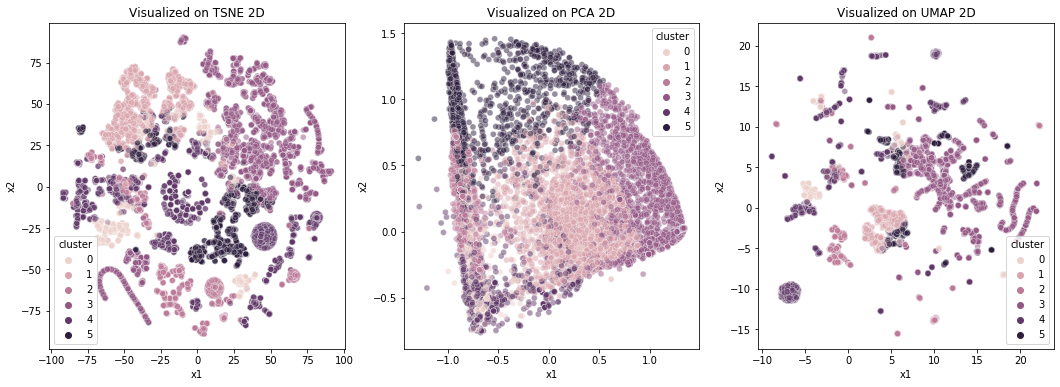

In [81]:
plot_tsne_and_pca(data, labels)

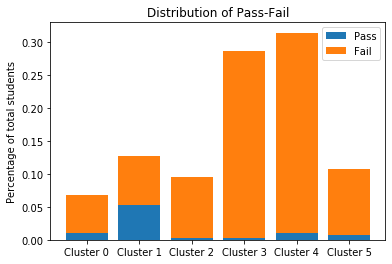

In [100]:
df = pd.DataFrame()
fail_pass = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    y_cluster = tf.gather(Y, list(cluster)).numpy()

    fail_pass.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(Y), (y_cluster == 1).sum()/len(Y)))
    
plt.bar([i[0] for i in fail_pass], [i[1] for i in fail_pass], label="Pass")
plt.bar([i[0] for i in fail_pass], [i[2] for i in fail_pass], bottom=[i[1] for i in fail_pass], label="Fail")
plt.title('Distribution of Pass-Fail')
plt.ylabel('Percentage of total students')
plt.legend()
plt.show()


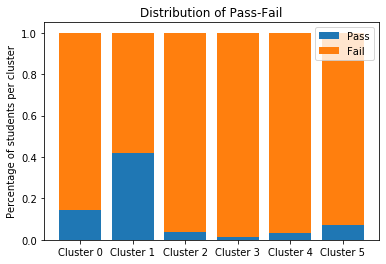

In [101]:
df = pd.DataFrame()
fail_pass = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    y_cluster = tf.gather(Y, list(cluster)).numpy()
    
    fail_pass.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(y_cluster), (y_cluster == 1).sum()/len(y_cluster)))

plt.bar([i[0] for i in fail_pass], [i[1] for i in fail_pass], label="Pass")
plt.bar([i[0] for i in fail_pass], [i[2] for i in fail_pass], bottom=[i[1] for i in fail_pass], label="Fail")
plt.title('Distribution of Pass-Fail')
plt.ylabel('Percentage of students per cluster')
plt.legend()
plt.show()

### Using truncated features

In [123]:
n = 7

data = X_masked
kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
labels = kmeans.labels_
silhouette_score(data, labels)

0.75003356

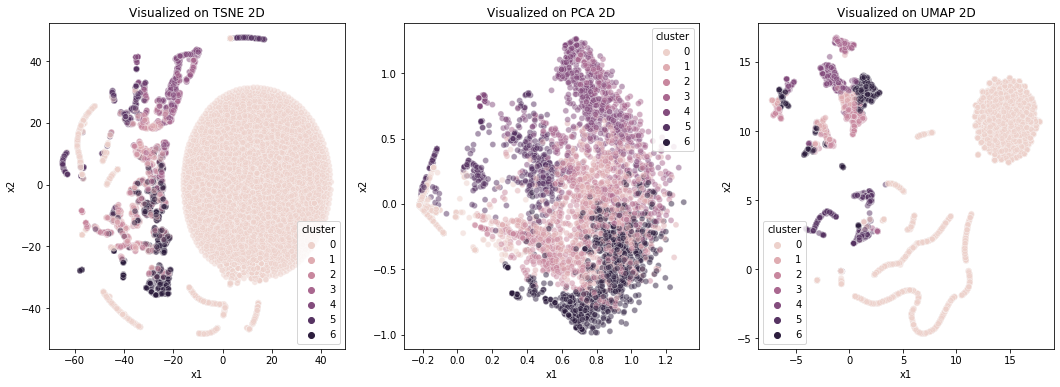

In [73]:
plot_tsne_and_pca(data, labels, pca_before=True)

60
514
314
168
125
78
270


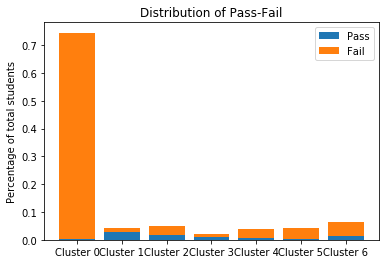

In [186]:
df = pd.DataFrame()
fail_pass = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    y_cluster = tf.gather(Y, list(cluster)).numpy()
    print((y_cluster ==0 ).sum())
    fail_pass.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(Y), (y_cluster == 1).sum()/len(Y)))
    
plt.bar([i[0] for i in fail_pass], [i[1] for i in fail_pass], label="Pass")
plt.bar([i[0] for i in fail_pass], [i[2] for i in fail_pass], bottom=[i[1] for i in fail_pass], label="Fail")
plt.title('Distribution of Pass-Fail')
plt.ylabel('Percentage of total students')
plt.legend()
plt.show()


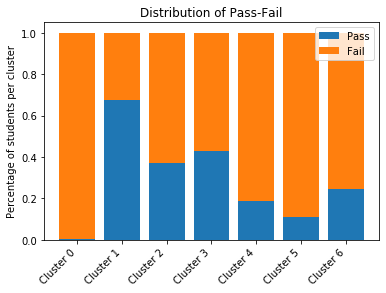

In [182]:
df = pd.DataFrame()
fail_pass = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    y_cluster = tf.gather(Y, list(cluster), axis=0).numpy()

    fail_pass.append(("Cluster "+str(c), (y_cluster == 0).sum()/len(y_cluster), (y_cluster == 1).sum()/len(y_cluster)))

plt.bar([i[0] for i in fail_pass], [i[1] for i in fail_pass], label="Pass")
plt.bar([i[0] for i in fail_pass], [i[2] for i in fail_pass], bottom=[i[1] for i in fail_pass], label="Fail")
plt.title('Distribution of Pass-Fail')
plt.ylabel('Percentage of students per cluster')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

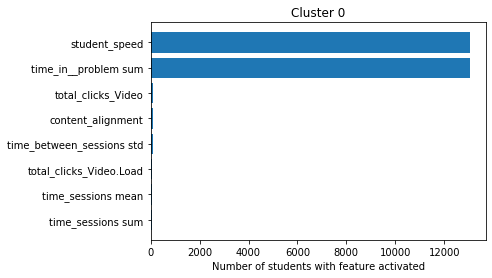

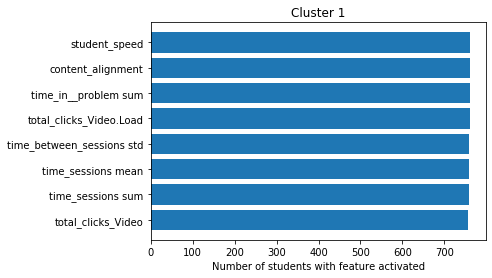

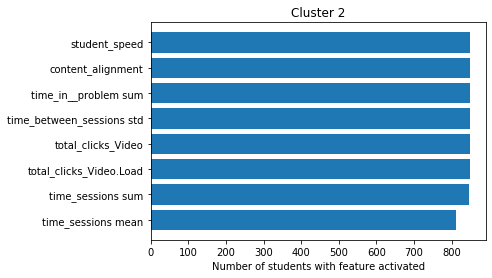

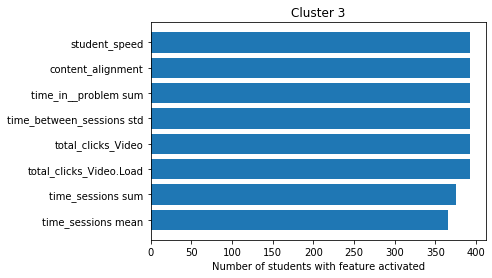

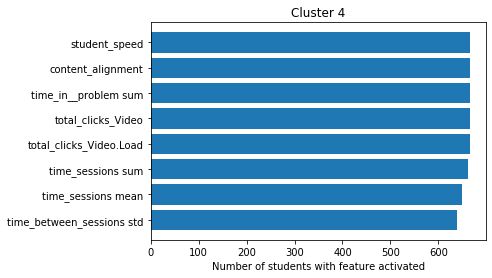

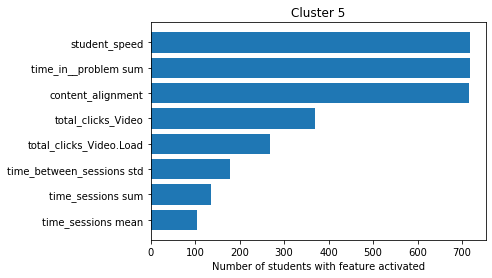

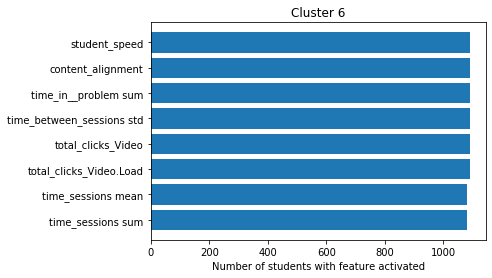

,Cluster,# instances,Avg Features
0,0,13039,2.031521
1,1,760,7.988158
2,2,848,7.957547
3,3,392,7.887755
4,4,665,7.933835
5,5,717,4.471409
6,6,1090,7.983486


In [110]:
df = pd.DataFrame()
clusters_length = []
avg_feat_per_cluster = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    cluster_length = len(cluster)
    clusters_length.append(cluster_length)
    avg_feat = np.mean(tf.reduce_sum(tf.gather(masks, list(cluster)), axis=1))
    avg_feat_per_cluster.append(avg_feat)
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
    f_activations = [(feature_names[i], f_activated[i].numpy()) for i in tf.where(f_activated)[:, 0]]
    f_activations = sorted(f_activations,key=itemgetter(1))
    plt.barh([i[0] for i in f_activations], [i[1] for i in f_activations])
    plt.title('Cluster '+str(c))
    plt.xlabel('Number of students with feature activated')
    plt.show()

df['Cluster'] = [i for i in range(n)]
df['# instances'] = clusters_length
df['Avg Features'] = avg_feat_per_cluster
df

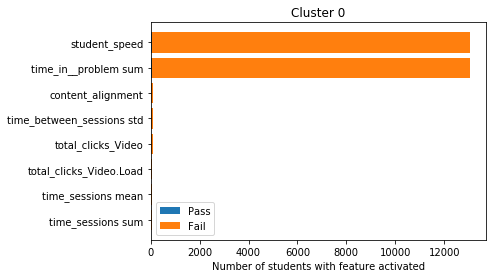

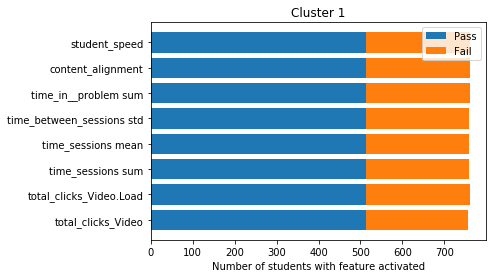

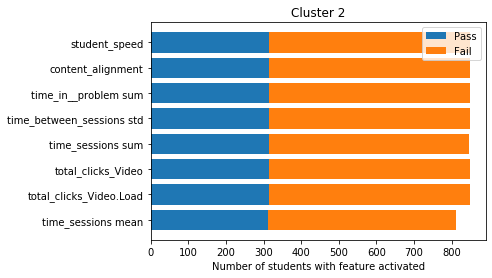

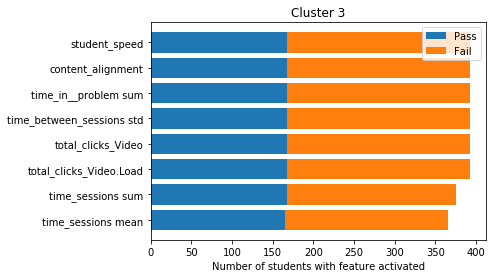

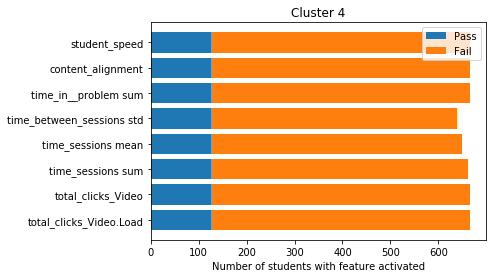

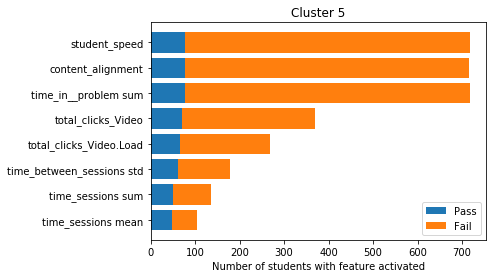

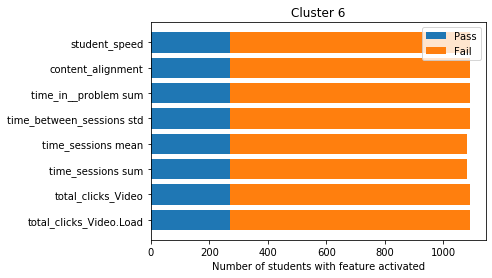

In [183]:
clusters_length = []
avg_feat_per_cluster = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

    f_students = []
    for i in tf.where(f_activated)[:, 0]:
        a = np.where(masks[:, i] == 1)[0]
        a = list(set(a) & set(list(cluster)))
    
        f_students.append((feature_names[i], (Y[a] == 0).sum(), (Y[a] == 1).sum()))
    f_students = sorted(f_students,key=itemgetter(1))

    plt.barh([i[0] for i in f_students], [i[1] for i in f_students], label="Pass")
    plt.barh([i[0] for i in f_students], [i[2] for i in f_students], left=[i[1] for i in f_students], label="Fail")
    plt.title('Cluster '+str(c))
    plt.xlabel('Number of students with feature activated')
    plt.legend()
    plt.show()


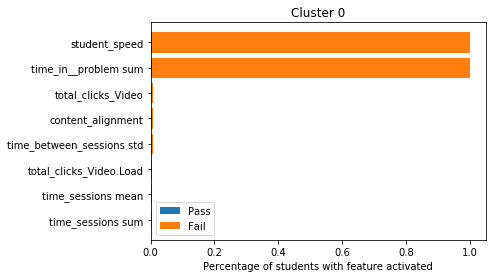

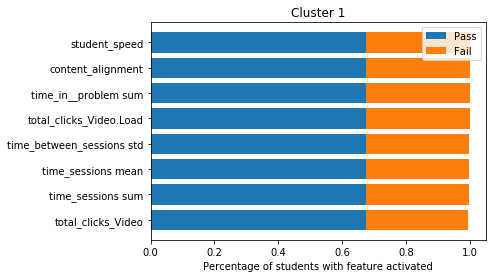

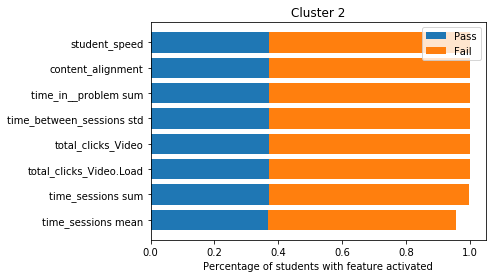

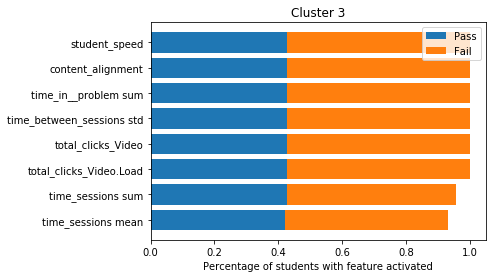

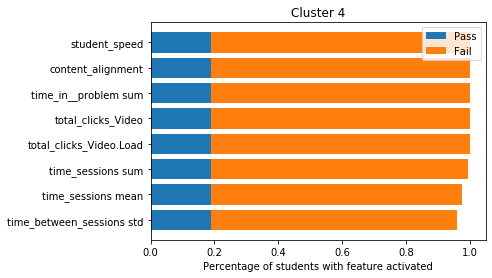

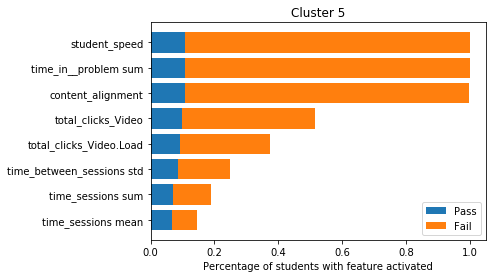

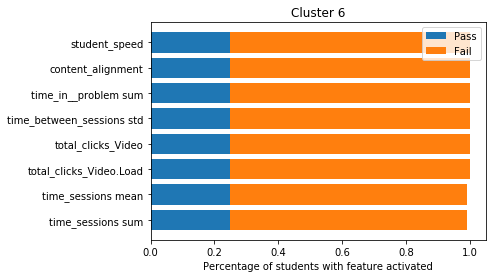

In [192]:
clusters_length = []
avg_feat_per_cluster = []
for c in range(n):
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

    f_students = []
    for i in tf.where(f_activated)[:, 0]:
        a = np.where(masks[:, i] == 1)[0]
        a = list(set(a) & set(list(cluster)))
        
        f_students.append((feature_names[i], [(Y[a] == 0).sum()/len(cluster), (Y[a] == 1).sum()/len(cluster)]))
   
    f_students = sorted(f_students, key=lambda x: sum(x[1]))

    plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass")
    plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail")
    plt.title('Cluster '+str(c))
    plt.xlabel('Percentage of students with feature activated')
    plt.legend()
    plt.show()


Cluster 0


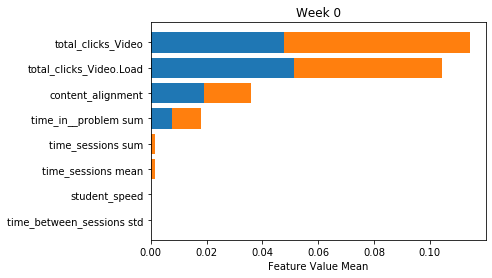

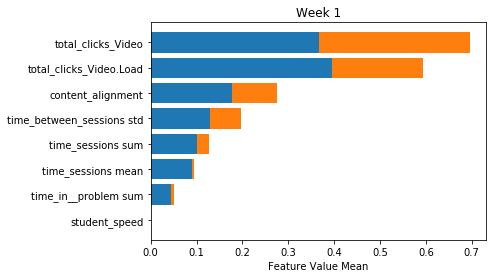

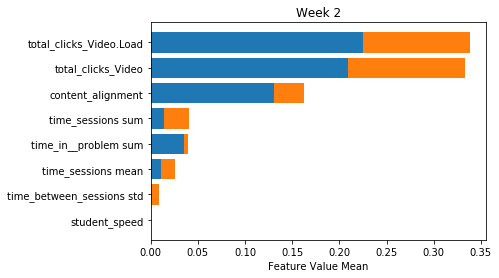

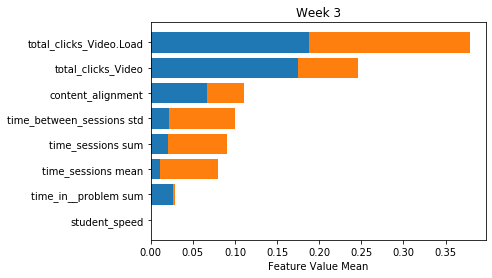

Cluster 1


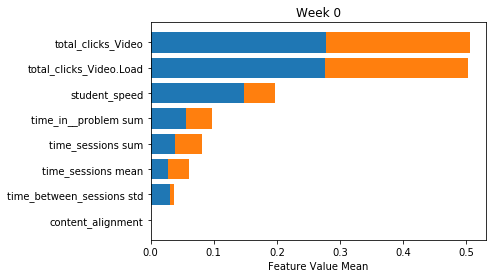

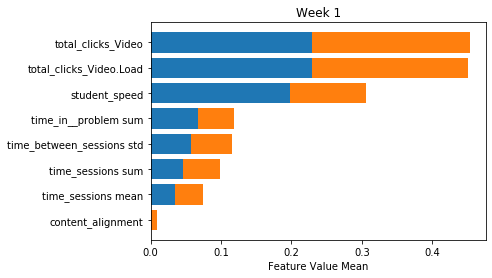

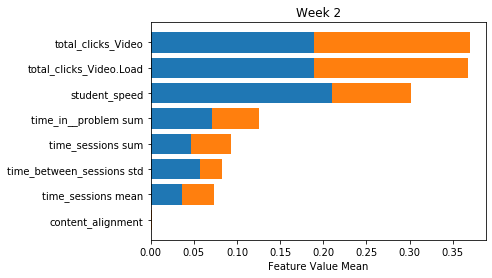

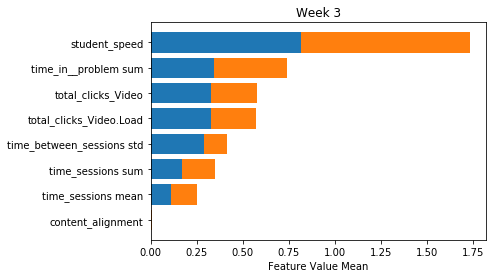

Cluster 2


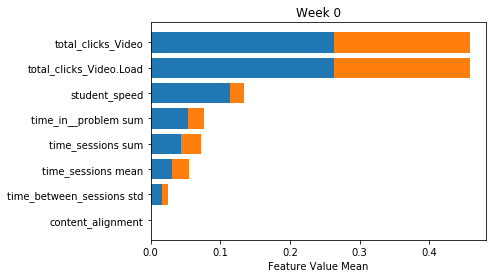

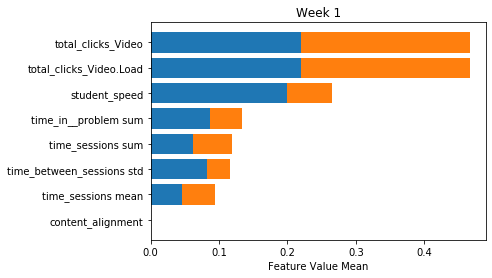

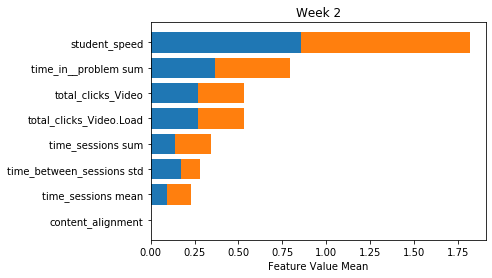

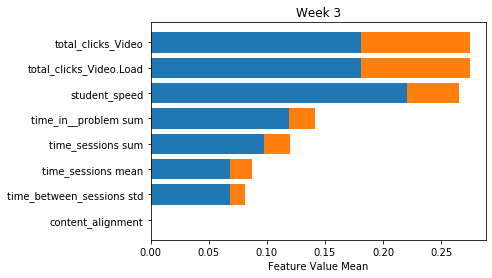

Cluster 3


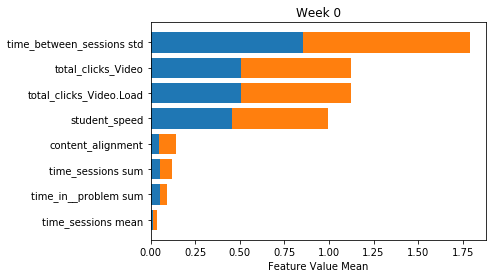

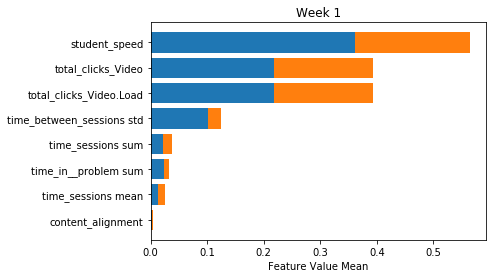

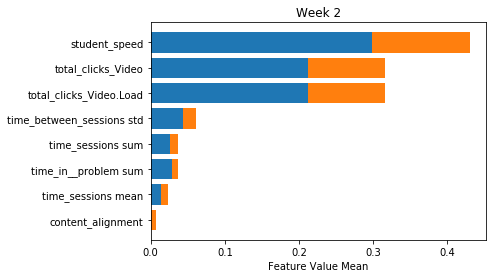

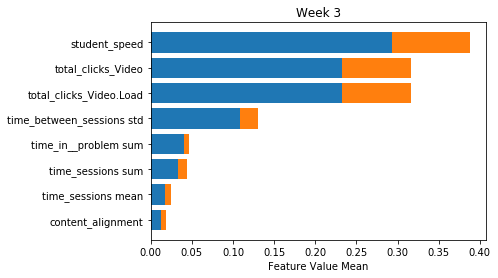

Cluster 4


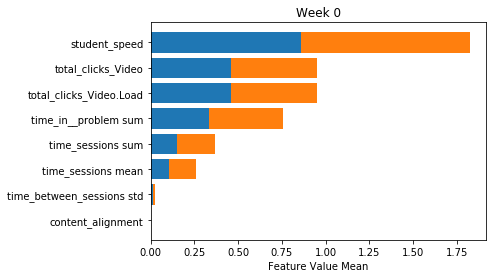

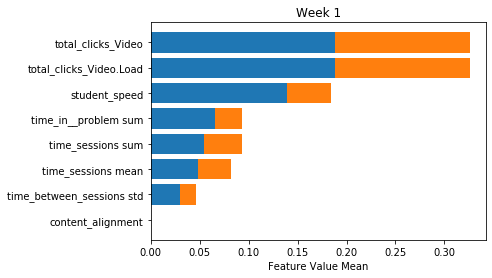

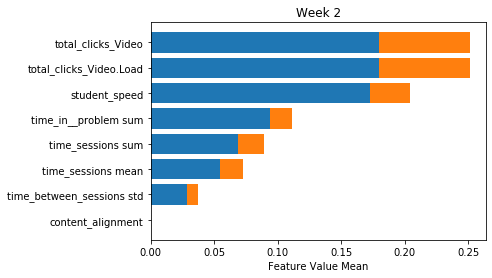

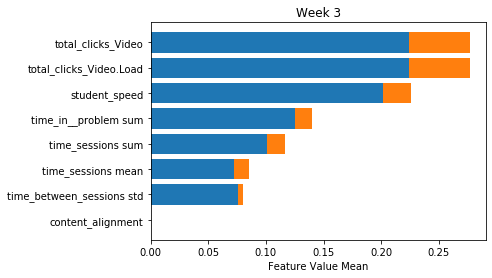

Cluster 5


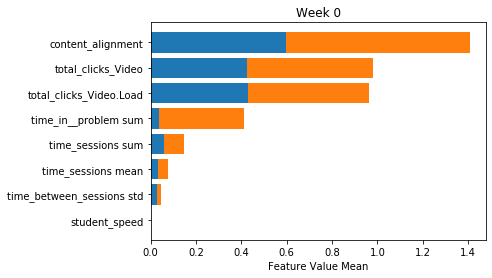

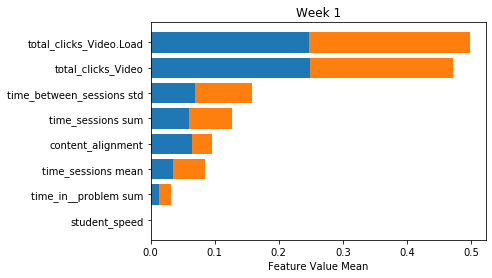

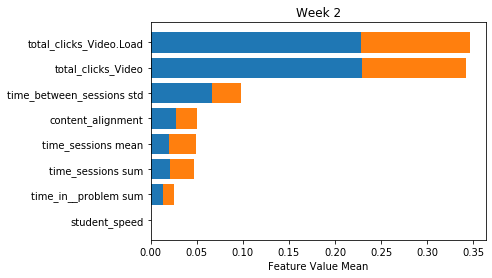

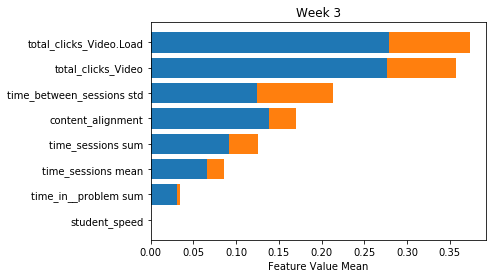

Cluster 6


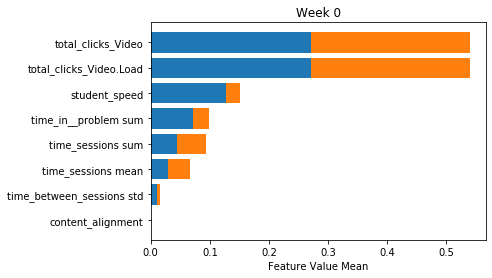

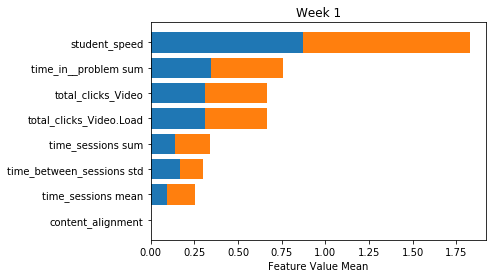

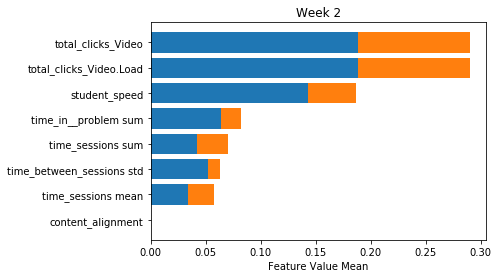

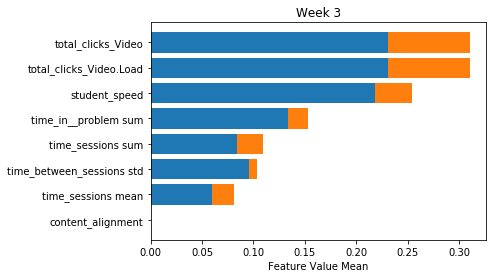

In [179]:
clusters_length = []
avg_feat_per_cluster = []
weeks = [0, 1, 2, 3]
for c in range(n):
    print('Cluster {0}'.format(c))
    for w in weeks:
        cluster = np.where(labels == c)[0]
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

        f_students = []
        for i in tf.where(f_activated)[:, 0]:
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster)))

            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
    
            f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, w, i]), 
                               tf.reduce_mean(X[target_1, w, i])]))

        f_students = sorted(f_students, key=lambda x: sum(x[1]))

        plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students])
        plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students])
        plt.title('Week '+str(w))
        plt.xlabel('Feature Value Mean')
        plt.show()


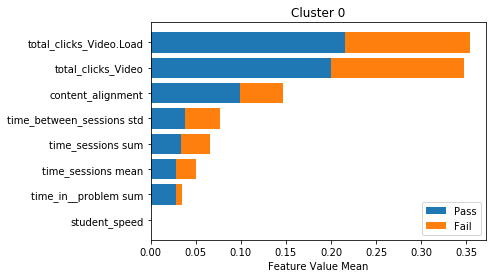

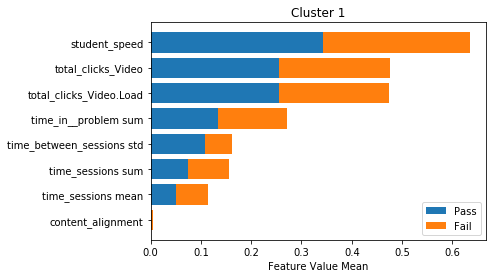

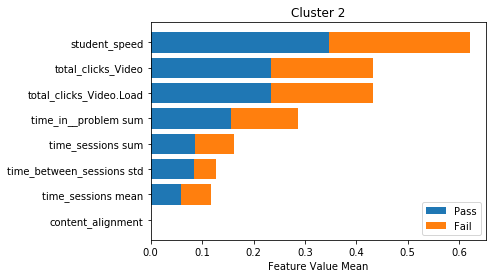

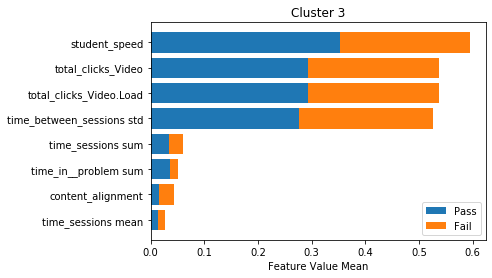

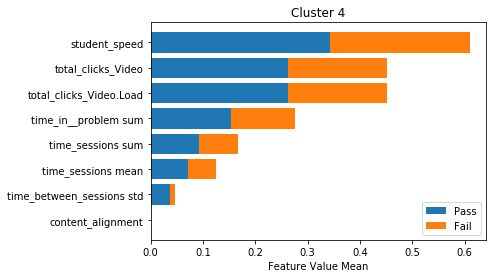

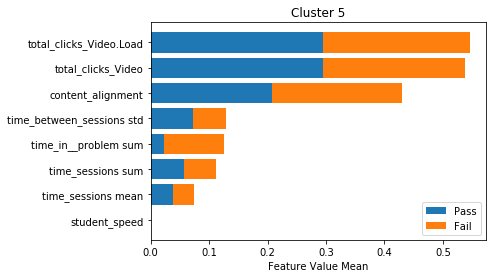

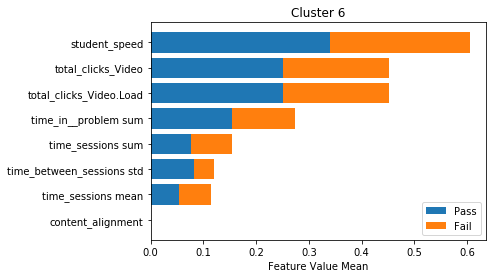

In [180]:
clusters_length = []
avg_feat_per_cluster = []
for c in range(n):
    
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

    f_students = []
    for i in tf.where(f_activated)[:, 0]:
        a = np.where(masks[:, i] == 1)[0]
        a = list(set(a) & set(list(cluster))) 
        
        target_0 = [j for j in a if Y[j] == 0]
        target_1 = [j for j in a if Y[j] == 1]

        f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i]), 
                           tf.reduce_mean(X[target_1, :, i])]))

    f_students = sorted(f_students, key=lambda x: sum(x[1]))

    plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass")
    plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail")
    plt.title('Cluster '+str(c))
    plt.xlabel('Feature Value Mean')
    plt.legend()
    plt.show()


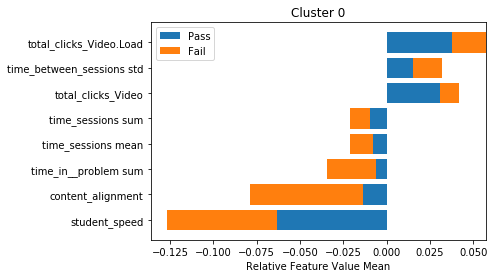

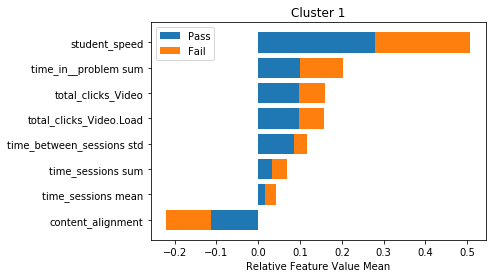

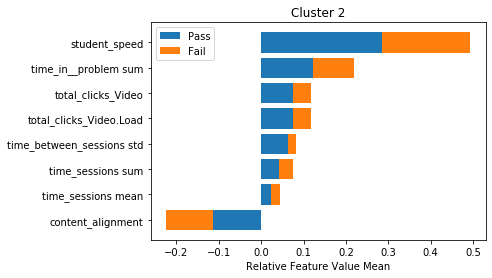

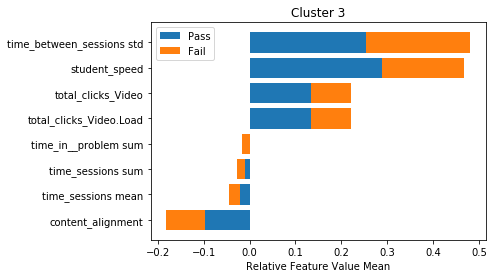

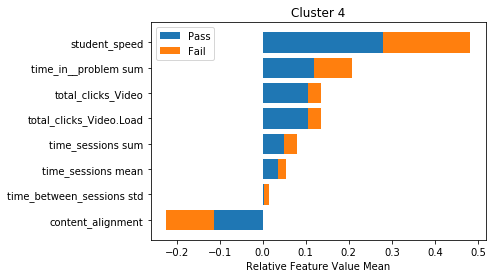

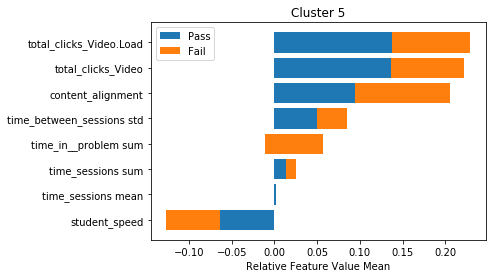

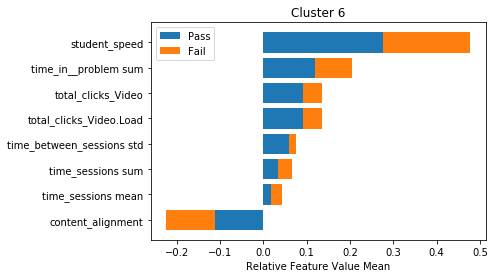

,Feature,Avg Value,Max Value
0,total_clicks_Video.Load,0.158125,0.706994
1,total_clicks_Video,0.158125,0.706994
2,time_sessions sum,0.043256,0.755853
3,time_sessions mean,0.035770,0.632445
4,time_between_sessions std,0.022277,0.999924
5,time_in__problem sum,0.034393,1.000000
6,content_alignment,0.112510,1.000000
7,student_speed,0.063489,1.000000


In [216]:
df = pd.DataFrame()
clusters_length = []
avg_feat_per_cluster = []

for c in range(n):
    cluster = np.where(labels == c)[0]
    f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)

    f_students = []
    for i in tf.where(f_activated)[:, 0]:
        a = np.where(masks[:, i] == 1)[0]
        a = list(set(a) & set(list(cluster))) 
        
        target_0 = [j for j in a if Y[j] == 0]
        target_1 = [j for j in a if Y[j] == 1]

        f_students.append((feature_names[i], [tf.reduce_mean(X[target_0, :, i])-tf.reduce_mean(X[:, :, i]), 
                           tf.reduce_mean(X[target_1, :, i])-tf.reduce_mean(X[:, :, i])]))
        
    f_students = sorted(f_students, key=lambda x: sum(x[1]))
    

    plt.barh([i[0] for i in f_students], [i[1][0] for i in f_students], label="Pass")
    plt.barh([i[0] for i in f_students], [i[1][1] for i in f_students], left=[i[1][0] for i in f_students], label="Fail")
    plt.title('Cluster '+str(c))
    plt.xlabel('Relative Feature Value Mean')
    plt.legend()
    plt.show()
    
f_mean = []
f_names = []
f_max = []
f_min = []
f_meadian = []
for i in tf.where(f_activated)[:, 0]:
    f_mean.append(tf.reduce_mean(X[:, :, i]).numpy())
    f_max.append(tf.reduce_max(X[:, :, i]).numpy())
    f_names.append(feature_names[i])

df['Feature'] = f_names
df['Avg Value'] = f_mean
df['Max Value'] = f_max
df